
# Multilabel classification using a classifier chain
This example shows how to use :class:`~sklearn.multioutput.ClassifierChain` to solve
a multilabel classification problem.

The most naive strategy to solve such a task is to independently train a binary
classifier on each label (i.e. each column of the target variable). At prediction
time, the ensemble of binary classifiers is used to assemble multitask prediction.

This strategy does not allow to model relationship between different tasks. The
:class:`~sklearn.multioutput.ClassifierChain` is the meta-estimator (i.e. an estimator
taking an inner estimator) that implements a more advanced strategy. The ensemble
of binary classifiers are used as a chain where the prediction of a classifier in the
chain is used as a feature for training the next classifier on a new label. Therefore,
these additional features allow each chain to exploit correlations among labels.

The `Jaccard similarity <jaccard_similarity_score>` score for chain tends to be
greater than that of the set independent base models.


In [1]:
# Author: Adam Kleczewski
# License: BSD 3 clause

## Loading a dataset
For this example, we use the [yeast](https://www.openml.org/d/40597) dataset which contains
2,417 datapoints each with 103 features and 14 possible labels. Each
data point has at least one label. As a baseline we first train a logistic
regression classifier for each of the 14 labels. To evaluate the performance of
these classifiers we predict on a held-out test set and calculate the
Jaccard similarity for each sample.



In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load a multi-label dataset from https://www.openml.org/d/40597
X, Y = fetch_openml("yeast", version=4, return_X_y=True)
Y = Y == "TRUE"
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Fit models
We fit :class:`~sklearn.linear_model.LogisticRegression` wrapped by
:class:`~sklearn.multiclass.OneVsRestClassifier` and ensemble of multiple
:class:`~sklearn.multioutput.ClassifierChain`.

### LogisticRegression wrapped by OneVsRestClassifier
Since by default :class:`~sklearn.linear_model.LogisticRegression` can't
handle data with multiple targets, we need to use
:class:`~sklearn.multiclass.OneVsRestClassifier`.
After fitting the model we calculate Jaccard similarity.



In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.multiclass import OneVsRestClassifier

base_lr = LogisticRegression()
ovr = OneVsRestClassifier(base_lr)
ovr.fit(X_train, Y_train)
Y_pred_ovr = ovr.predict(X_test)
ovr_jaccard_score = jaccard_score(Y_test, Y_pred_ovr, average="samples")

### Chain of binary classifiers
Because the models in each chain are arranged randomly there is significant
variation in performance among the chains. Presumably there is an optimal
ordering of the classes in a chain that will yield the best performance.
However, we do not know that ordering a priori. Instead, we can build a
voting ensemble of classifier chains by averaging the binary predictions of
the chains and apply a threshold of 0.5. The Jaccard similarity score of the
ensemble is greater than that of the independent models and tends to exceed
the score of each chain in the ensemble (although this is not guaranteed
with randomly ordered chains).



### Classifier Chain vs. OneVsRestClassifier

#### OneVsRestClassifier (OVR)

The OneVsRestClassifier (OVR) strategy involves training a single classifier per class, with the samples of that class as positive samples and all other samples as negatives. This approach is straightforward and works well for multi-class classification problems. However, it does not model the correlations between classes, which can be a significant limitation in multi-label classification tasks where the presence of one class can affect the presence of another.

#### Classifier Chain

Classifier Chain (CC) is an extension of the multi-label classification that models label dependencies. Instead of treating each label independently, it trains a sequence of classifiers, each considering the previous predictions as additional features. This method allows capturing the correlations between labels.

Formally, for a dataset with $n$ samples and $m$ labels, let $X$ be the feature matrix and $Y$ be the label matrix. For each label $j \in \{1, \dots, m\}$, a classifier $h_j$ is trained to predict the $j$-th label $Y_j$ using the original features $X$ and the predictions of all previous classifiers $h_1, \dots, h_{j-1}$. Mathematically, the prediction for the $j$-th label is:

$$
\hat{y}_j = h_j(x, \hat{y}_1, \hat{y}_2, \ldots, \hat{y}_{j-1})
$$

where:
- $\hat{y}_j$ is the predicted value of the $j$-th label.
- $x$ is the input feature vector.
- $\hat{y}_1, \hat{y}_2, \ldots, \hat{y}_{j-1}$ are the predictions of the previous classifiers.

#### Advantages of Classifier Chain

1. **Modeling Dependencies**: Classifier Chains can capture and utilize the dependencies between labels. If the presence of one label makes another label more likely, this information can improve the overall prediction accuracy.

2. **Improved Performance**: By incorporating the predicted labels as features, the classifiers in the chain can make more informed decisions, often leading to better performance compared to independent classifiers.

3. **Flexibility**: The order of the chain can be optimized or randomized, allowing multiple chains to be trained and their predictions to be averaged for even better performance. This ensemble approach reduces the variance and improves the robustness of the predictions.

#### Main Arguments of `ClassifierChain` in scikit-learn

- `base_estimator`: The base estimator to fit on each label. This is often a simple classifier like Logistic Regression.
- `order`: The order of the chain. Can be 'random' to use a random order, or an array specifying a specific order of labels.
- `cv`: Determines the cross-validation splitting strategy.
- `random_state`: The seed of the pseudo-random number generator to use for randomizing the chain order.

#### Why Classifier Chain is Better Than OVR?

- **Correlation Awareness**: OVR treats each label independently, ignoring potential correlations between labels. Classifier Chains, on the other hand, incorporate the predictions of previous labels, capturing interdependencies.
- **Enhanced Predictive Power**: By leveraging the information from other labels, Classifier Chains can improve the predictive performance, especially in scenarios where labels are not independent.
- **Ensemble Capability**: Multiple chains with different orders can be combined to form an ensemble, which averages the predictions, leading to more robust and accurate results.

In summary, Classifier Chains offer a sophisticated approach to multi-label classification by modeling label dependencies, resulting in better performance and flexibility compared to the OVR strategy.


In [4]:
from sklearn.multioutput import ClassifierChain

chains = [ClassifierChain(base_lr, order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

Y_pred_chains = np.array([chain.predict_proba(X_test) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(Y_test, Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(
    Y_test, Y_pred_ensemble >= 0.5, average="samples"
)

## Plot results
Plot the Jaccard similarity scores for the independent model, each of the
chains, and the ensemble (note that the vertical axis on this plot does
not begin at 0).



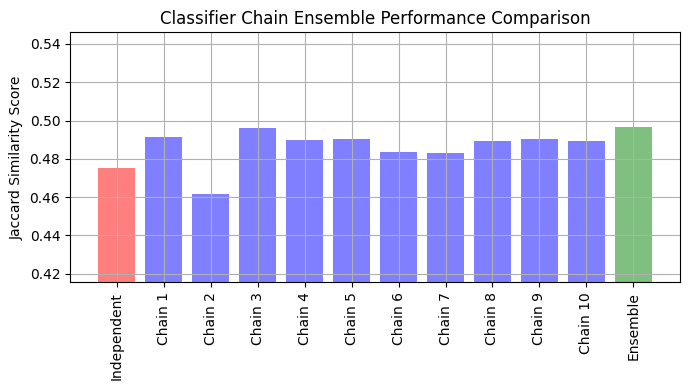

In [5]:
model_scores = [ovr_jaccard_score] + chain_jaccard_scores + [ensemble_jaccard_score]

model_names = (
    "Independent",
    "Chain 1",
    "Chain 2",
    "Chain 3",
    "Chain 4",
    "Chain 5",
    "Chain 6",
    "Chain 7",
    "Chain 8",
    "Chain 9",
    "Chain 10",
    "Ensemble",
)

x_pos = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["r"] + ["b"] * len(chain_jaccard_scores) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

## Results interpretation
There are three main takeaways from this plot:

- Independent model wrapped by :class:`~sklearn.multiclass.OneVsRestClassifier`
  performs worse than the ensemble of classifier chains and some of individual chains.
  This is caused by the fact that the logistic regression doesn't model relationship
  between the labels.
- :class:`~sklearn.multioutput.ClassifierChain` takes advantage of correlation
  among labels but due to random nature of labels ordering, it could yield worse
  result than an independent model.
- An ensemble of chains performs better because it not only captures relationship
  between labels but also does not make strong assumptions about their correct order.

